# Meridional Overturning

`mom6_tools.moc` functions for computing and plotting meridional overturning. 

The goal of this notebook is the following:

1) server as an example on to compute a meridional overturning streamfunction (global and Atalntic) from CESM/MOM output; 

2) evaluate model experiments by comparing transports against observed estimates;

3) compare model results vs. another model results (TODO).

In [2]:
%matplotlib inline
import matplotlib
import numpy as np
import xarray as xr
# mom6_tools
from mom6_tools.moc import  *
from mom6_tools.m6toolbox import check_time_interval, genBasinMasks 
import matplotlib.pyplot as plt


In [4]:
# The following parameters must be set accordingly
######################################################
# case name - must be changed for each configuration
case_name = 'g.c2b6.GNYF.T62_t061.long_run_nuopc.001'
# Path to the run directory
path = "/glade/scratch/gmarques/g.c2b6.GNYF.T62_t061.long_run_nuopc.001/run/"
# initial and final years for computing time mean
year_start = 80
year_end = 90
# add your name and email address below
author = 'Gustavo Marques (gmarques@ucar.edu)'
######################################################
# create an empty class object
class args:
  pass

args.infile = path
args.static = 'g.c2b6.GNYF.T62_t061.long_run_nuopc.001.mom6.static.nc'
args.monthly = 'g.c2b6.GNYF.T62_t061.long_run_nuopc.001.mom6.hm_*nc'
args.year_start = year_start
args.year_end = year_end
args.case_name = case_name
args.label = ''
args.savefigs = False

In [5]:
stream = True
# mom6 grid
grd = MOM6grid(args.infile+args.static)
depth = grd.depth_ocean
# remote Nan's, otherwise genBasinMasks won't work
depth[numpy.isnan(depth)] = 0.0
basin_code = m6toolbox.genBasinMasks(grd.geolon, grd.geolat, depth)

# load data
ds = xr.open_mfdataset(args.infile+args.monthly,decode_times=False)
# convert time in years
ds['time'] = ds.time/365.
ti = args.year_start
tf = args.year_end
# check if data includes years between ti and tf
check_time_interval(ti,tf,ds)

# create a ndarray subclass
class C(numpy.ndarray): pass

if 'vmo' in ds.variables:
  varName = 'vmo'; conversion_factor = 1.e-9
elif 'vh' in ds.variables:
  varName = 'vh'; conversion_factor = 1.e-6
  if 'zw' in ds.variables: conversion_factor = 1.e-9 # Backwards compatible for when we had wrong units for 'vh'
else: raise Exception('Could not find "vh" or "vmo" in file "%s"'%(args.infile+args.static))
  

tmp = np.ma.masked_invalid(ds[varName].sel(time=slice(ti,tf)).mean('time').data)
tmp = tmp[:].filled(0.)
VHmod = tmp.view(C)
VHmod.units = ds[varName].units


Zmod = m6toolbox.get_z(ds, depth, varName)

if args.case_name != '':  case_name = args.case_name + ' ' + args.label
else: case_name = rootGroup.title + ' ' + args.label


MOM6 grid successfully loaded... 

11.16428 64.78855 [391, 434]


/glade/u/home/gmarques/miniconda3/envs/analysis/lib/python3.7/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


# Global MOC

(60, 458) (60, 458) (60, 458)


Text(0.5, 0.98, 'g.c2b6.GNYF.T62_t061.long_run_nuopc.001 ')

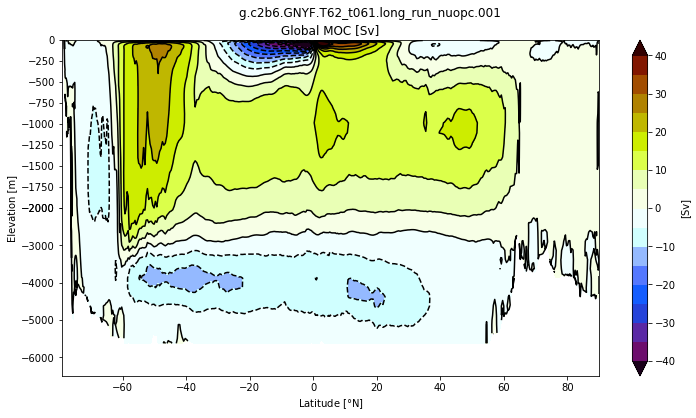

In [16]:
# Global MOC
m6plot.setFigureSize([16,9],576,debug=False)
axis = plt.gca()
cmap = plt.get_cmap('dunnePM')
z = Zmod.min(axis=-1); psiPlot = MOCpsi(VHmod)*conversion_factor
psiPlot = 0.5 * (psiPlot[0:-1,:]+psiPlot[1::,:])
#yy = y[1:,:].max(axis=-1)+0*z
yy = grd.geolat_c[:,:].max(axis=-1)+0*z
print(z.shape, yy.shape, psiPlot.shape)
ci=m6plot.pmCI(0.,40.,5.)
plotPsi(yy, z, psiPlot, ci, 'Global MOC [Sv]')
plt.xlabel(r'Latitude [$\degree$N]')
plt.suptitle(case_name)
#findExtrema(yy, z, psiPlot, max_lat=-30.)
#findExtrema(yy, z, psiPlot, min_lat=25.)
#findExtrema(yy, z, psiPlot, min_depth=2000., mult=-1.)

# Atlantic MOC

Text(0.5, 0.98, 'g.c2b6.GNYF.T62_t061.long_run_nuopc.001 ')

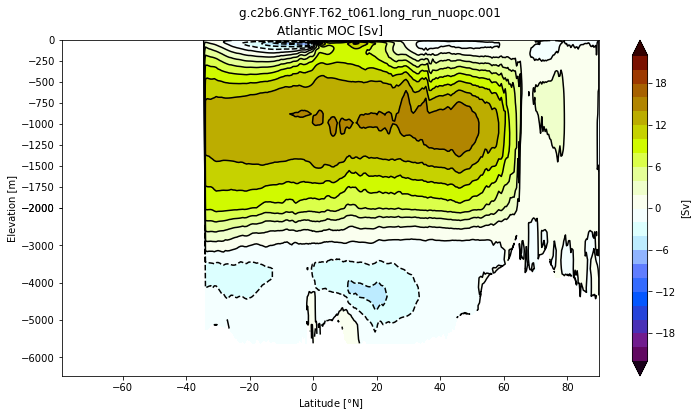

In [17]:
m6plot.setFigureSize([16,9],576,debug=False)
cmap = plt.get_cmap('dunnePM')
m = 0*basin_code; m[(basin_code==2) | (basin_code==4) | (basin_code==6) | (basin_code==7) | (basin_code==8)]=1
ci=m6plot.pmCI(0.,22.,2.)
z = (m*Zmod).min(axis=-1); psiPlot = MOCpsi(VHmod, vmsk=m*numpy.roll(m,-1,axis=-2))*conversion_factor
psiPlot = 0.5 * (psiPlot[0:-1,:]+psiPlot[1::,:])
#yy = y[1:,:].max(axis=-1)+0*z
yy = grd.geolat_c[:,:].max(axis=-1)+0*z
plotPsi(yy, z, psiPlot, ci, 'Atlantic MOC [Sv]')
plt.xlabel(r'Latitude [$\degree$N]')
plt.suptitle(case_name)

# Time series